## U-Net+residual blocks: A modified U-Net inspired by the Kaggle Carvana Image Masking Challenge solutions


Date created: Oct 10, 2017   
Last modified: Feb 3, 2018  
Tags: U-Net, semantic segmentation, CNNs, dilated convolutions, residual block  
About: modified U-Nets

The U-Net <a href="#ref1">[1]</a> was the most widely implemented deep learning network in the recently concluded [Carvana Image Masking Challenge](https://www.kaggle.com/c/carvana-image-masking-challenge) on Kaggle and the competition was an opportunity to experiment with different 
[U-Net](#UNet) architectures. The [third place solution](https://www.kaggle.com/c/carvana-image-masking-challenge/discussion/40199) ([github code](https://github.com/lyakaap/Kaggle-Carvana-3rd-place-solution)) was a modified  U-Net that used dilated convolution blocks in the bottleneck region (the region at the junction of the contracting and expanding paths). This simple change, which was responsible for the high scoring (0.997193) results, used fewer parameters (8.5 million vs something in the range of 34 million for a lower scoring U-Net model 7 or 8 blocks deep) as well. [Dilated convolutional filters](#dilated) increase the receptive field but require far fewer parameters than a deeper network with standard convolution filters. Since the ResNet <a href="#ref1">[2]</a> is a deep network that uses fewer parameters (than older conv-net architectures), a worthwhile experiment would be to replace the dilated convolutions with ResNet [residual blocks](#residual-blocks).

In this exercise we will compare the *U-Net+residual blocks* network with the *U-Net+dilated blocks*. A template for these two modified U-Net architectures is shown below:  


![](UNet.png)


#### Methodology
There are two or three runs -- some with small changes -- for each of the models. We plot the [results](#Results) for all five runs but show the model summary, data prep, and training steps only for the *U-Net+residual blocks* Run 5.  
We only train the models for 5-10 epochs to see how the performance numbers in the initial phase compare. It would take roughly three days (50 mins/epoch x 100 epochs on a NVIDIA Tesla K80 GPU platform) to fully train each model and a full set of experiments with multiple runs would be expensive. 

The models are implemented in Keras with the TensorFlow backend. 

#### Acknowledgment
The use of the following code is acknowledged:
  1. [Image processing](https://github.com/petrosgk/Kaggle-Carvana-Image-Masking-Challenge) code from Kaggle user Peter Giannakopoulos
  2. [U-Net+dilated conv and loss function](https://github.com/lyakaap/Kaggle-Carvana-3rd-Place-Solution) code from Kaggle user @lyakaap
  3. [Resnet50 residual block](https://github.com/fchollet/keras/blob/master/keras/applications/resnet50.py) code from the Keras project


#### Organization
The rest of the notebook is organized into the following sections:  
  1. [Brief description of U-Net, Dilated convolutions and ResNet residual blocks](#Basics) for context.
  2. [Model summary](#Model)
  3. [Data preparation](#Data)
  4. [Initial training results from *U-Net+residual blocks*](#resblock_unet_training)
  5. [Compare results from for U-Net+{dilated blocks, residual blocks}](#Results)
 

<a id='Basics'></a>
## Basics of U-Net, Dilated Convolutions and Residual Blocks

<a id='UNet'></a>
#### U-Net
The U-Net is an example of a FCN Encoder-Decoder architecture. The Encoder is a standard convolutional neural network which learns features for classification. During this process, downsampling operations reduce the spatial resolution, so an upsampling stage is needed to restore the spatial resolution for semantic segmentation. This is achieved by the Decoder network. The SegNet is an example of an Encoder-Decoder where two VGG16 networks, one a downsampling path and the other an upsampling path, mirror each other. In the U-Net, the downsampling and upsampling path are connected via a convolutional block. This set of convolutional filters lets the network go deeper and preserves the dimensions of the contracted segmentation maps at the same time. Some variants of this block could be the use of dilated convolutions or a bottleneck layer.

<a id='dilated'></a>
#### Dilated Convolutional Filters
Dilated (or atrous) convolutional filters are used in semantic segmentation architectures to increase the receptive field but to do so with far fewer parameters than a deeper network with standard convolution filters would require. To see why, note that a 3x3 filter with a dilation rate of 2 has the same FOV as a 5x5 filter. The 3x3 filter uses 9 parameters whereas the 5x5 filter uses 25. (It should be noted that while the max pooling operation also increases the FOV it is also associated with aggressive downsampling and so is not used in a U-Net once the features are learned.) 

<a id='residual-blocks'></a>
#### Residual Blocks
ResNets employ residual blocks to create deep networks. The basic residual block consists of a sequence of convolutional layers chained by a skip connection which ensures that the input signal is backpropagated.  The ResNet50 residual block that we use is made up of three sequential convolutions:
  1. 1x1 convolutions (this is the NiN concept: features that are correlated are efficiently combined reducing redundancy and this reduces the number of parameters effectively creating a *bottleneck*)
  2. 3x3 convolutions (to get a rich set of new feature combinations; this is computationally expensive but due to the preceding bottleneck step the computational burden is significantly reduced) 
  3. 1x1 operation (to expand the number of filters usually restoring the output to the original block input)
  
This is shown in the figure below:

![](bottleneck.png)

## Import libraries

In [4]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.losses import binary_crossentropy
import keras.backend as K

from sklearn.model_selection import train_test_split
import h5py
import random

import losses
import models
import augmentation

DATAPATH = "../data"

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


<a id='Model'></a>
## Models

The *U-Net+dilated blocks (dilated_unet)* model has 8.6 million parameters; the bottleneck has 6 dilated convolutions. The model architecture is shown [here](https://github.com/lyakaap/Kaggle-Carvana-3rd-Place-Solution/blob/master/network.png).

The *U-Net+residual blocks (resblock_unet)* uses one convolution + 5 residual blocks. This model uses 3.6 million parameters which is less than half of dilated_unet. The model summary is shown below.

In [5]:
model = new_models.get_resblock_unet(input_shape=(512,512, 3))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
enc_conv_1a (Conv2D)            (None, 512, 512, 44) 1232        input_1[0][0]                    
__________________________________________________________________________________________________
enc_conv_1b (Conv2D)            (None, 512, 512, 44) 17468       enc_conv_1a[0][0]                
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 44) 0           enc_conv_1b[0][0]                
__________________________________________________________________________________________________
enc_conv_2

## Data, Preprocessing, Augmentation <a id='Data'></a>

#### Data
The training dataset consists of 5088 images. Each car is presented in 16 fixed photo angles. The ground truth training mask images were converted from *.gif* to *.png* format so as to be compatible with the *OpenCV* library. 

The Carvana dataset can be found [here](https://www.kaggle.com/c/carvana-image-masking-challenge/data). The training images and ground truth masks are in the *train* and *train_masks* folders respectively. The test data was not used.

In [5]:
df_train = pd.read_csv(DATAPATH+'/train_masks.csv')

In [6]:
df_train = df_train.iloc[2:,:]

In [8]:
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [9]:
ids_train_split, ids_valid_split = train_test_split(ids_train, test_size=0.2, random_state=42)

#### Preprocessing  -- rescaling (input and mask data)
The original image resolution of 1918 x 1280 was downsampled to 512 x 512 using the OpenCV library functions.

In [13]:
input_width = 512
input_height = 512
max_epochs = 10
orig_width = 1918
orig_height= 1280
threshold  = 0.5

In [10]:
all_imgs  = {}
all_masks = {}

for id in ids_train:
    img  = cv2.imread(DATAPATH+'/train/{}.jpg'.format(id))
    img  = cv2.resize(img, (input_width, input_height))
    mask = cv2.imread(DATAPATH+'/train_masks_png/{}_mask.png'.format(id), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (input_width, input_height))
    all_imgs[id]  = img
    all_masks[id] = mask

#### Augmentation

The following transformations using the *OpenCV* library were made:
* Hue, Saturation, Value using randomHueSaturationValue
* Shift, Scale, Rotate using randomShiftScaleRotate
* Horizontal flips using randomHorizontalFlip

## Training
<a id='resblock_unet_training'></a>

In [12]:
def train_generator(train_batch_size):
    while True:
        this_ids_train_split = random.sample(list(ids_train_split), len(ids_train_split))
        for start in range(0, len(ids_train_split), train_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + train_batch_size, len(ids_train_split))
            ids_train_batch = this_ids_train_split[start:end]
            for id in ids_train_batch:
                img  = all_imgs[id]
                mask = all_masks[id]
                img = augmentation.randomHueSaturationValue(img,
                                               hue_shift_limit=(-50, 50),
                                               sat_shift_limit=(-5, 5),
                                               val_shift_limit=(-15, 15))
                img, mask = augmentation.randomShiftScaleRotate(img, mask,
                                                   shift_limit=(-0.0625, 0.0625),
                                                   scale_limit=(-0.1, 0.1),
                                                   rotate_limit=(-0, 0))
                img, mask = augmentation.randomHorizontalFlip(img, mask)
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch


In [13]:
def valid_generator(val_batch_size):
    while True:
        for start in range(0, len(ids_valid_split), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids_valid_split))
            ids_valid_batch = ids_valid_split[start:end]
            for id in ids_valid_batch.values:
                img  = all_imgs[id]
                mask = all_masks[id]
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch


In [14]:
train_batch_size = 6
val_batch_size   = 16

In [15]:
callbacks = [ReduceLROnPlateau(monitor='val_dice_coef',
                               factor=0.2,
                               patience=3,
                               verbose=1,
                               epsilon=1e-4,
                               mode='max'),
             ModelCheckpoint(monitor='val_dice_coef',
                             filepath='../weights/best_weights_resblock_1.hdf5',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')]

history = model.fit_generator(generator=train_generator(train_batch_size),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(train_batch_size)),
                    epochs=max_epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(val_batch_size),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(val_batch_size)))


Epoch 1/10
 - 2391s - loss: 0.1446 - dice_coef: 0.9391 - val_loss: 0.7907 - val_dice_coef: 0.7309
Epoch 2/10
 - 2235s - loss: 0.0451 - dice_coef: 0.9815 - val_loss: 0.0524 - val_dice_coef: 0.9791
Epoch 3/10
 - 2235s - loss: 0.0358 - dice_coef: 0.9857 - val_loss: 0.0646 - val_dice_coef: 0.9750
Epoch 4/10
 - 2231s - loss: 0.0282 - dice_coef: 0.9885 - val_loss: 0.0279 - val_dice_coef: 0.9886
Epoch 5/10
 - 2233s - loss: 0.0246 - dice_coef: 0.9899 - val_loss: 1.9311 - val_dice_coef: 0.6366
Epoch 6/10
 - 2235s - loss: 0.0223 - dice_coef: 0.9909 - val_loss: 0.5545 - val_dice_coef: 0.8320
Epoch 7/10
 - 2235s - loss: 0.0194 - dice_coef: 0.9920 - val_loss: 0.0254 - val_dice_coef: 0.9900
Epoch 8/10
 - 2221s - loss: 0.0186 - dice_coef: 0.9924 - val_loss: 0.0180 - val_dice_coef: 0.9925
Epoch 9/10
 - 2213s - loss: 0.0168 - dice_coef: 0.9930 - val_loss: 0.0166 - val_dice_coef: 0.9932
Epoch 10/10
 - 2214s - loss: 0.0160 - dice_coef: 0.9933 - val_loss: 0.1499 - val_dice_coef: 0.9600


## Results  <a id='Results'></a>

There are five runs:   
- *U-Net+dilated blocks*: Runs 1, 2   
- *U-Net+residual blocks*: Runs 3, 4, 5  

The model summary, data prep and training run were shown for the *U-Net+residual blocks* Run 5 above. Below we plot the following results for the five runs:   
- dice coefficient   
- training loss 

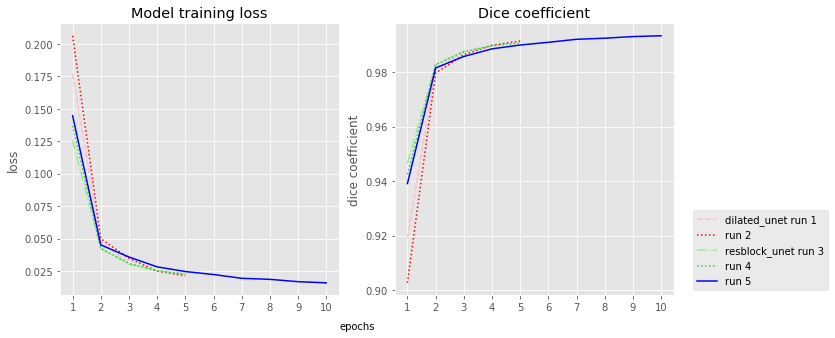

In [20]:
# aggregated run data from history.history for 5 runs
d1_dice = [0.9191, 0.9808, 0.9873]
d2_dice = [0.9027, 0.9796, 0.9864, 0.9898, 0.9914]
r3_dice = [0.9465, 0.9827, 0.9876, 0.9896]
r4_dice = [0.9425, 0.9827, 0.9874, 0.9896, 0.9907]
r5_dice = [0.9391, 0.9815, 0.9857, 0.9885, 0.9899, 
           0.9909, 0.9920, 0.9924, 0.9930, 0.9933]
dice_list = [d1_dice, d2_dice, r3_dice, r4_dice, r5_dice]

d1_loss = [0.1768, 0.0474, 0.0312]
d2_loss = [0.2062, 0.0499, 0.0348, 0.0249, 0.0213]
r3_loss = [0.1255,0.0424,0.0302,0.0253,0.02265]
r4_loss = [0.1368, 0.0423, 0.0309, 0.0252, 0.0225]
r5_loss = [0.1446,0.0451, 0.0358, 0.0282, 0.0246,
           0.0223,0.0194,0.0186,0.0168,0.0159]
loss_list = [d1_loss, d2_loss, r3_loss, r4_loss, r5_loss]

# plot
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(11,5))
plt.style.use('ggplot')

colors = ['pink', 'red', 'lightgreen','limegreen', 'blue']
linestyles =['--',':','-.',':', '-'] 
legend_list = ['dilated_unet run 1', 'run 2', 'resblock_unet run 3', 'run 4', 'run 5']


for i, color, linestyle in zip(range(5), colors, linestyles):
    ax[0].plot(loss_list[i], color = color, linestyle=linestyle)
    ax[1].plot(dice_list[i], color = color, linestyle=linestyle)

ax[0].set_title('Model training loss')
ax[1].set_title('Dice coefficient')

ax[0].set_ylabel('loss')
ax[1].set_ylabel('dice coefficient')
plt.xticks(range(10), range(1,11))
fig.text(0.5, 0.04, 'epochs', ha='center', va='center')
plt.legend(legend_list, bbox_to_anchor=(1.05, 0), loc='lower left');

## Discussion

The initial numbers (from 10 epochs for Run 5, 5 epochs for the other runs) for both the *U-Net+residual blocks* and the *U-Net+dilated blocks* are comparable and both are very high in terms of the dice coefficients. The U-Net is a good baseline for binary segmentation but these start values were much higher than for a generic U-Net without the modified bottleneck. 
There is some indication that the *U-Net+dilated blocks* is more stable but we would need to train longer and tune each of these runs to assess that.  

The U-Nets were trained from scratch using an NVIDIA Tesla K80 GPU computing platform. It took around 40-50 mins per epoch.
The *U-Net+dilated blocks* with 8.6 million parameters took longer than the *U-Net+residual blocks*  with 3.5 million parameters. The run times are listed below.

*U-Net+dilted blocks*
* 3300 secs for the first 5 epochs on two runs
               
*U-Net+residual blocks* 
* 2700 secs for the first 5 epochs on two runs
* 2250 secs for first 10 epochs (the experiments were run a month apart during which time the code was rewritten and there is also the possibility the computing resources on the Crestle platform changed)

The *U-Net+residual blocks* seems like it could be a time-efficient replacement for the *U-Net+dilated blocks*. 

## References and Further Reading

<a name="ref1"></a>[1] [Olaf Ronneberger, Philipp Fischer, Thomas Brox. "U-Net: Convolutional Networks for Biomedical Image Segmentation." arXiv:1505.04597v1 [cs.CV]](https://arxiv.org/pdf/1505.04597.pdf)

<a name="ref2"></a>[2] [He, Kaiming, et al. "Deep Residual Learning for Image Recognition." arXiv:1512.03385v1 [cs.CV]](https://arxiv.org/pdf/1512.03385.pdf)

[3] [Pröve, Paul-Louis. "An Introduction to different Types of Convolutions in Deep Learning." Towards Data Science/Medium, Jul 22 2017](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)

[4] [Culurciello, Eugenio. "Neural Network Architectures" Towards Data Science/Medium, Mar 23 2017](https://towardsdatascience.com/neural-network-architectures-156e5bad51ba)

**
Author:  Meena Mani      
Email:   meenas.mailbag@gmail.com      
Twitter: @meena_uvaca    
**